32
(X shape, y shape, every X's mean, every X's standard deviation)
(343, 180, 32) (30, 1) 0.5266575 0.15453486

The dataset has not been preprocessed, is not normalised etc
Iter #32:  Learning rate = 0.000100:   Batch Loss = 9.630241, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 9.454567909240723, Accuracy = 0.36666667461395264
Iter #640:  Learning rate = 0.000100:   Batch Loss = 9.479645, Accuracy = 0.3125
PERFORMANCE ON TEST SET:             Batch Loss = 9.38018798828125, Accuracy = 0.46666666865348816
Iter #1280:  Learning rate = 0.000100:   Batch Loss = 9.346441, Accuracy = 0.34375
PERFORMANCE ON TEST SET:             Batch Loss = 9.281814575195312, Accuracy = 0.6666666865348816
Iter #1920:  Learning rate = 0.000100:   Batch Loss = 9.303483, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 9.207037925720215, Accuracy = 0.6000000238418579
Iter #2560:  Learning rate = 0.000100:   Batch Loss = 9.268062, Accuracy = 0.5
PERFORMANCE ON TEST SET:    

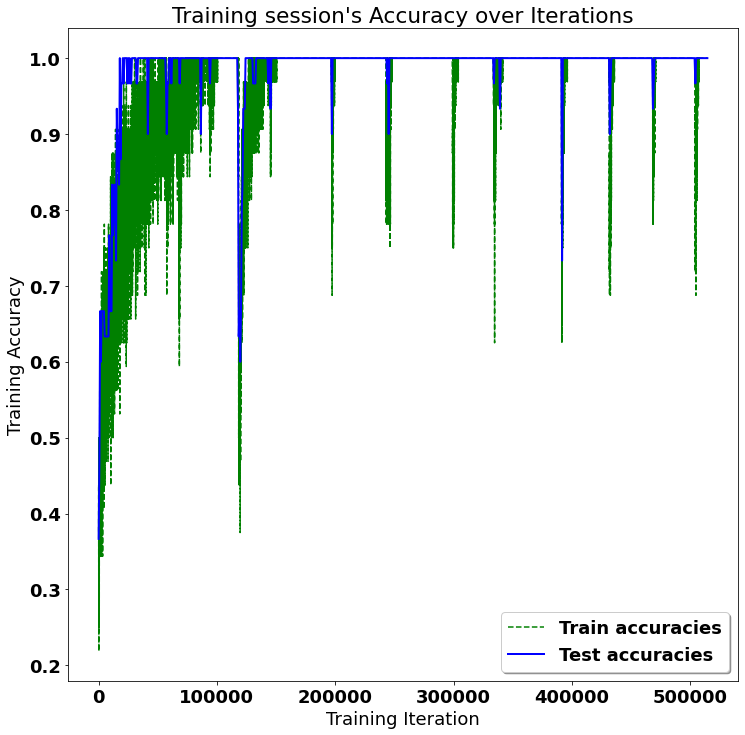

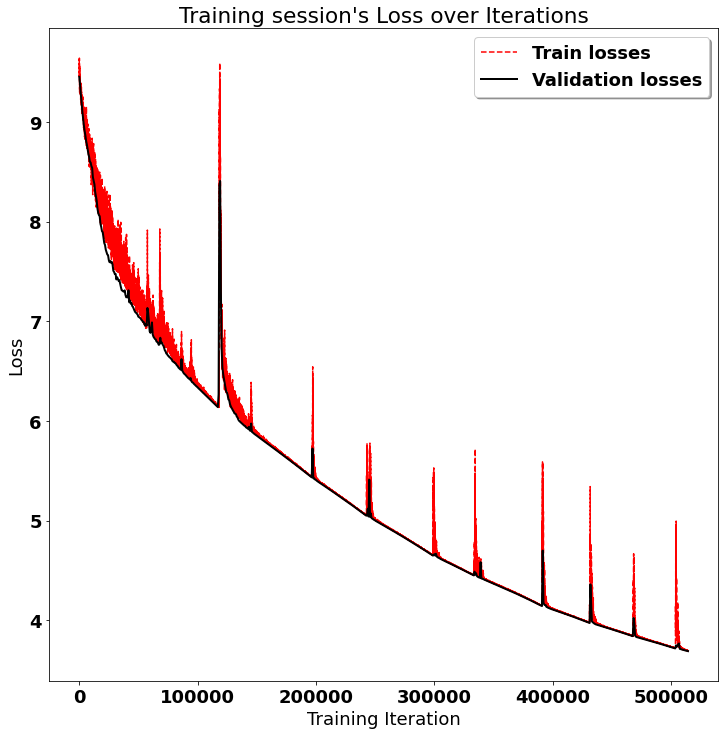

Testing Accuracy: 100.0%

Precision: 100.0%
Recall: 100.0%
f1_score: 100.0%

Confusion Matrix:
Created using test set of 30 datapoints, normalised to % of each class in the test dataset


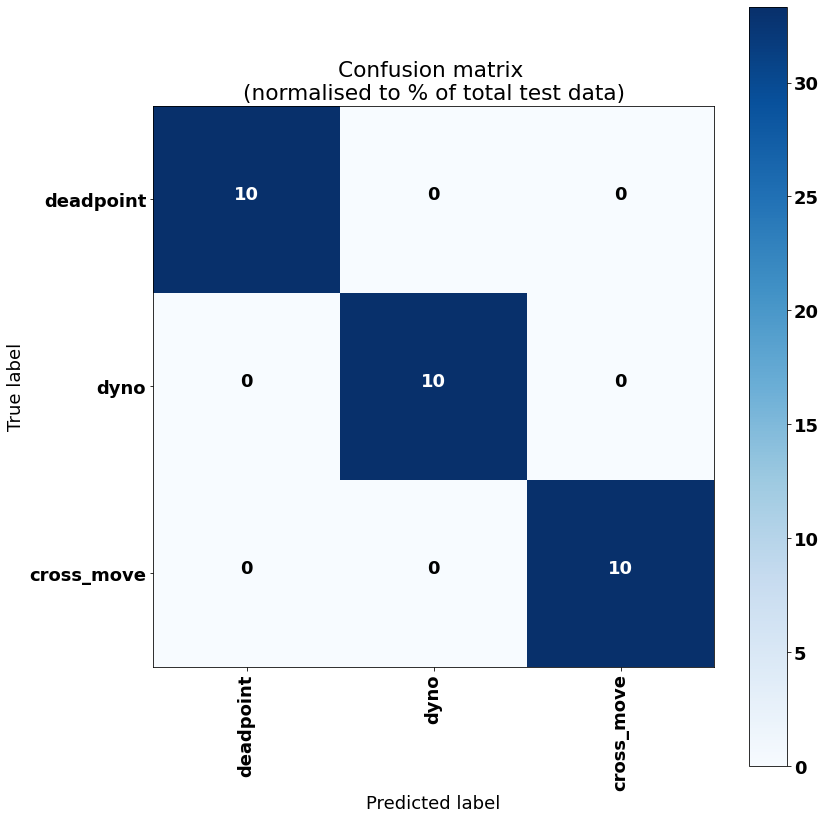

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
tf.reset_default_graph() # <--- これを追加
from sklearn import metrics
import random
from random import randint
import time
import os
import itertools

# Output classes to learn how to classify
LABELS = [#"heel_hook",  
    "deadpoint" ,
    "dyno" ,
    "cross_move" 
] 


#学習データのパス
DATASET_PATH = "data/HAR_pose_activities/database/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 180 # 32 timesteps per series


# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))
    
    return X_ 
    
# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)

# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

print(n_input)

n_hidden = 36 # Hidden layer num of features　もとは34
n_classes = 3  #元々は6クラス 

#updated for learning-rate decay
# calculated as: decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True #False
learning_rate = 0.0001 #学習率(学習率が変化しない場合の固定値学習率)
init_learning_rate = 0.0001 #学習率(学習率が変化する場合の初期学習率)
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.01

training_iters = training_data_count *1500  # Loop 300 times on the dataset, ie 300 epochs
batch_size =32  #元々は512
display_iter = batch_size*20  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")


def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    #n_values = int(np.max(y_)) + 1
    # 列数はデータの最大値ではなく、モデルで定義したクラス数 (n_classes) を使う
    n_values = n_classes 
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = list(range(0,len(X_train)))

while step * batch_size <= training_iters:
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = list(range(0,len(X_train))) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print (len(test_accuracies))
print (len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()
#--------------------------------------------------------------------------------------------------------
#Lossのプロットコード

# Lossのプロット (ここからが追加するコード)
plt.figure(figsize=(width, height)) # 新しい図 (2つ目の図) を作成

# TrainLossのプロット
# train_losses は各バッチ処理ごとに記録されています。
# X軸は train_accuracies と同じ indep_train_axis を使用できます。
# train_losses と train_accuracies は同じ回数記録されているはずです。
if len(train_losses) == len(indep_train_axis): # 念のため長さを確認
    plt.plot(indep_train_axis, np.array(train_losses), "r--", label="Train losses")
else:
    # もし長さが異なる場合の代替X軸 (イテレーション数ベース)
    # これは train_losses が display_iter ごとではなく、全ステップで記録されていることを前提としています。
    # 元のコードでは train_losses は全ステップで記録されています。
    train_loss_iterations = np.array(range(1, len(train_losses) + 1)) * batch_size
    plt.plot(train_loss_iterations, np.array(train_losses), "r--", label="Train losses (all steps)")


# ValidationLoss (TestLoss) のプロット
# X軸は test_accuracies と同じ indep_test_axis を使用できます。
# test_losses と test_accuracies は同じ回数記録されているはずです。
plt.plot(indep_test_axis, np.array(test_losses), "k-", linewidth=2.0, label="Validation losses")

plt.title("Training session's Loss over Iterations") # タイトル変更
plt.legend(loc='upper right', shadow=True) # 凡例の位置
plt.ylabel('Loss') # Y軸ラベル変更
plt.xlabel('Training Iteration')

plt.show() # Lossプロットの表示 (2つ目の図が表示されます)
#------------------------------------------------------------------------------------------------------------------

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
# ここからが追加したコードブロックです
# -----------------------------------------------------------------
# 各セルに分類されたサンプル数を書き込む
thresh = normalised_confusion_matrix.max() / 2.
for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    # 背景色に合わせてテキストの色を白か黒に設定
    plt.text(j, i, format(confusion_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if normalised_confusion_matrix[i, j] > thresh else "black")
# -----------------------------------------------------------------
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

 
# X_val_path = DATASET_PATH + "X_val.txt"
# X_val = load_X(X_val_path)
# print (X_val)

# preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
# )

# print (preds)

# sess.close()
# print (test_accuracies)